# Response Times and Internal Delay

Inspired by a blog post on [latency in asynchronous Python](https://nullprogram.com/blog/2020/05/24/), I wanted to investigate how a specialized ASGI server ([uvicorn](https://www.uvicorn.org/)) and an asynchronous framework ([Starlette](https://www.starlette.io/)) handle this. By _this_ I mean that the blog post discusses how the asyncio event loop handles tasks in order so that the more tasks there are, the longer the delay until the same task is picked up again.

I started to wonder whether there was or maybe **should be** a priority on completing requests to a web framework. To this end, [I created a very simple web application](https://github.com/Midnighter/starlette-delay/) and challenged it with an increasing number of requests using [Locust](https://docs.locust.io/). The app itself records the delay caused by the number of tasks in the event loop and Locust records the response times.

Within this notebook I analyze the results from my experiment in the [repository](https://github.com/Midnighter/starlette-delay/). The experiment had the following settings:

* The application itself had a 1 s _heartbeat_ and recorded the delay in seconds to this heartbeat.
* An increasing number of requests are made to the application using Locust.
* Requests should be made approximately every 2 s and every 10 s the number of requests is incremented by 20.

If you wanted to analyze a different framework, it should be a simple matter to replace the Starlette app.

In [ ]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
sns.set()

In [4]:
delay = pd.read_csv("../data/delay.csv", header=0)
delay.sample(10)

,timestamp,delay
46,2020-06-11T16:55:32.584337+00:00,0.000257
93,2020-06-11T16:56:31.872104+00:00,1.190330
25,2020-06-11T16:55:10.685116+00:00,0.000403
102,2020-06-11T16:56:49.957560+00:00,0.001185
2,2020-06-11T16:54:47.511703+00:00,-0.000222
70,2020-06-11T16:55:59.123385+00:00,0.081790
7,2020-06-11T16:54:52.525317+00:00,0.000683
22,2020-06-11T16:55:07.639443+00:00,0.050650
97,2020-06-11T16:56:40.648147+00:00,1.182981
84,2020-06-11T16:56:16.092944+00:00,0.294731


In [5]:
delay.set_index(pd.to_datetime(delay["timestamp"]), verify_integrity=True, inplace=True)
delay.loc[delay["delay"] < 0.0, "delay"] = 0.0

In [6]:
delay.index = delay.index - delay.index[0]

In [7]:
stats = pd.read_csv("../data/delay_stats_history.csv")
stats.sample(10)

,Timestamp,User Count,Type,Name,Requests/s,Failures/s,50%,66%,75%,80%,...,99.99%,99.999%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
32,1591894521,80,GET,/json,30.5,0.0,100.0,140.0,190.0,220.0,...,520.0,520.0,520.0,747,0,62,99,12,518,27
113,1591894602,200,NaN,Aggregated,89.2,0.0,2200.0,2200.0,2200.0,2200.0,...,2200.0,2200.0,2200.0,6597,0,570,844,12,2212,27
75,1591894563,160,NaN,Aggregated,72.0,0.0,500.0,570.0,640.0,700.0,...,1300.0,1300.0,1300.0,3178,0,290,315,12,1271,27
15,1591894503,40,NaN,Aggregated,12.0,0.0,27.0,35.0,43.0,54.0,...,110.0,110.0,110.0,220,0,21,31,13,114,27
106,1591894596,200,GET,/json,91.1,0.0,2200.0,2200.0,2200.0,2200.0,...,2200.0,2200.0,2200.0,6084,0,520,733,12,2212,27
105,1591894594,200,NaN,Aggregated,88.5,0.0,2100.0,2200.0,2200.0,2200.0,...,2200.0,2200.0,2200.0,5794,0,490,661,12,2204,27
40,1591894529,100,GET,/json,37.2,0.0,180.0,240.0,290.0,320.0,...,740.0,740.0,740.0,1100,0,96,140,12,745,27
27,1591894515,60,NaN,Aggregated,25.4,0.0,85.0,110.0,120.0,140.0,...,390.0,390.0,390.0,540,0,36,67,13,393,27
79,1591894567,180,NaN,Aggregated,73.1,0.0,560.0,640.0,690.0,730.0,...,1300.0,1300.0,1300.0,3440,0,310,332,12,1271,27
82,1591894571,180,GET,/json,79.6,0.0,620.0,680.0,730.0,770.0,...,1300.0,1300.0,1300.0,3907,0,340,366,12,1348,27


In [8]:
stats.dropna(subset=("Type",), inplace=True)
stats.set_index(
    pd.to_datetime(stats["Timestamp"]) - pd.Timestamp("1970-01-01"), inplace=True
)

In [9]:
stats["Total Max Response Time"].max()

2219

In [10]:
first = min(delay.index.min(), stats.index.min())

In [11]:
last = max(delay.index.max(), stats.index.max())

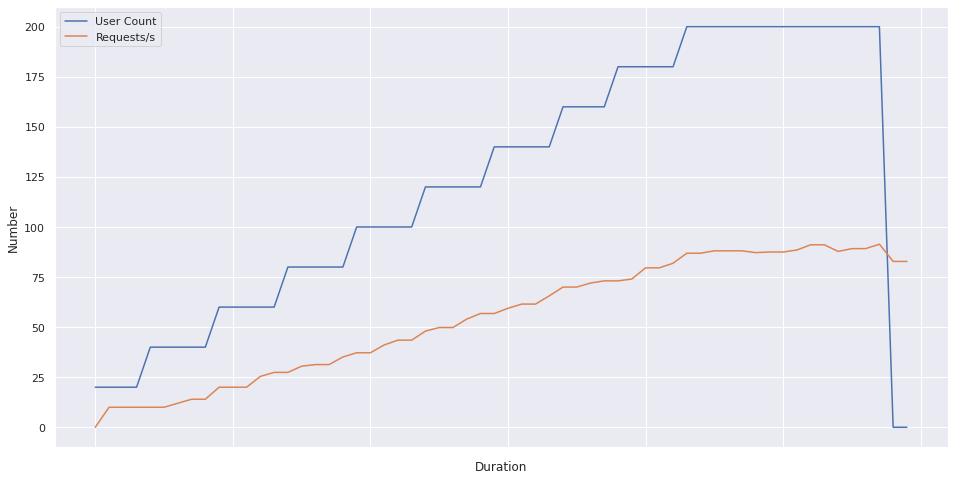

In [12]:
stats.plot(y=["User Count", "Requests/s"], figsize=(16, 9))
plt.xlabel("Duration")
plt.ylabel("Number")
plt.show()

Expect minimum of 12 ms.

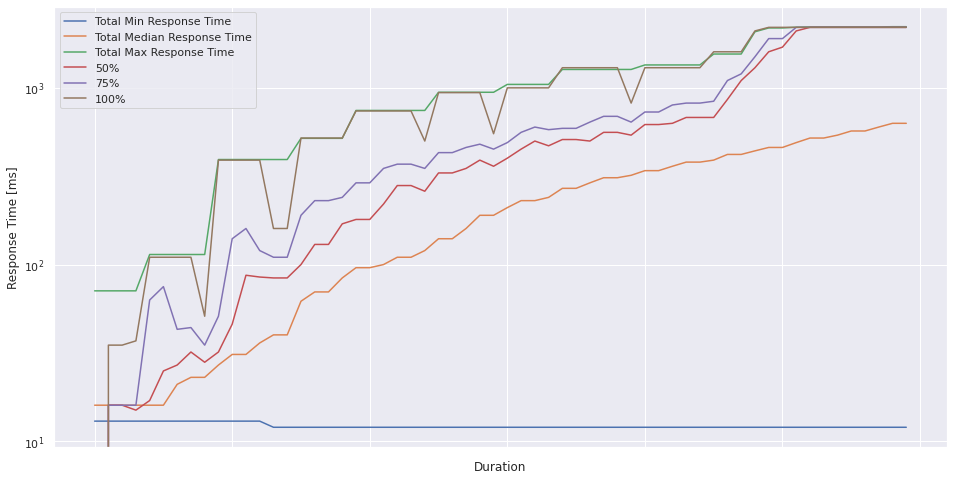

In [13]:
stats[
    [
        "Total Min Response Time",
        "Total Median Response Time",
        "Total Max Response Time",
        "50%",
        "75%",
        "100%",
    ]
].plot(logy=True, figsize=(16, 9))
plt.xlabel("Duration")
plt.ylabel("Response Time [ms]")
plt.show()

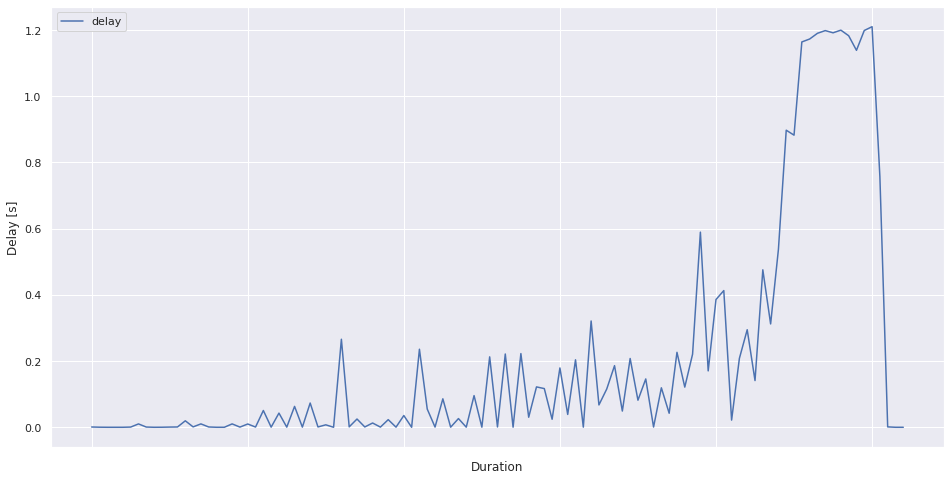

In [14]:
delay.plot(logy=False, figsize=(16, 9))
plt.xlabel("Duration")
plt.ylabel("Delay [s]")
plt.show()